# Decoding Market Signals: Candlestick patterns for the S&P 500 index

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from pathlib import Path
from collections import namedtuple
from scipy import stats

from BSquant import load_data
from BSquant import process_data
from BSquant import cs_pattern_recognition
from BSquant import cs_performance
from BSquant import plot_cs_performance
from BSquant import compute_trading_strategy_performance

pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

# Loading data for the S&P500

In [2]:
# Define the path to your ticker file
ticker_file = "./../data/SP500_tickers_one_per_line.txt"
notebooks_dir = Path("./../notebooks")
ticker_file_path = notebooks_dir.parent / "data" / ticker_file

tickers = []

# Open the ticker-file with a context manager and read each line adding ot to the list of tickers
with open(ticker_file_path, "r") as file:
    for line in file:
        ticker = line.strip()  # strip newline characters and whitespace
        tickers.append(ticker)  # add the cleaned ticker to the list

print("Number of tickers (may include multiple tickers per stock) is", len(tickers))
print("Number of unique tickers is:", set(tickers).__len__())

Number of tickers (may include multiple tickers per stock) is 503
Number of unique tickers is: 503


In [3]:
# enumerated tickers in the ticker_file
for i, ticker in enumerate(tickers):
    print(f"{i+1}:{ticker}")

1:MSFT
2:AAPL
3:AMZN
4:NVDA
5:GOOGL
6:META
7:GOOG
8:TSLA
9:BRK.B
10:UNH
11:LLY
12:JPM
13:XOM
14:V
15:AVGO
16:JNJ
17:PG
18:MA
19:HD
20:ADBE
21:COST
22:MRK
23:CVX
24:ABBV
25:CRM
26:PEP
27:KO
28:WMT
29:BAC
30:ACN
31:NFLX
32:MCD
33:LIN
34:CSCO
35:AMD
36:TMO
37:INTC
38:ORCL
39:ABT
40:CMCSA
41:PFE
42:DIS
43:WFC
44:VZ
45:INTU
46:DHR
47:PM
48:IBM
49:AMGN
50:QCOM
51:NOW
52:TXN
53:COP
54:UNP
55:SPGI
56:NKE
57:GE
58:BA
59:HON
60:CAT
61:AMAT
62:RTX
63:T
64:NEE
65:LOW
66:SBUX
67:ELV
68:GS
69:BKNG
70:UPS
71:ISRG
72:PLD
73:MDT
74:BLK
75:BMY
76:TJX
77:MS
78:LMT
79:SYK
80:DE
81:AXP
82:MMC
83:AMT
84:MDLZ
85:PGR
86:GILD
87:LRCX
88:ADP
89:CB
90:ADI
91:VRTX
92:SCHW
93:ETN
94:PANW
95:C
96:REGN
97:CVS
98:MU
99:SNPS
100:BSX
101:ZTS
102:BX
103:FI
104:CME
105:TMUS
106:CI
107:SO
108:EQIX
109:MO
110:KLAC
111:CDNS
112:SLB
113:EOG
114:DUK
115:BDX
116:NOC
117:ITW
118:AON
119:SHW
120:ICE
121:CL
122:CSX
123:MCK
124:PYPL
125:WM
126:TGT
127:CMG
128:APD
129:HUM
130:FDX
131:MPC
132:USB
133:ORLY
134:MCO
135:PSX
136:ROP
137

## Remove rows with missing data

In [4]:
data_filename = "SP500_daily_data_1980_to_2023.csv.gz"
notebooks_dir = Path("./../notebooks")
data_file_path = notebooks_dir.parent / "data" / data_filename
print(data_file_path)

../data/SP500_daily_data_1980_to_2023.csv.gz


In [5]:
%time
# passing a function as argument to another function; load all data we got
df = process_data(load_data(file_path=data_file_path, compression="gzip"))

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.53 µs


In [6]:
df.shape

(3169549, 13)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169549 entries, 0 to 3169548
Data columns (total 13 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ticker                object        
 1   date                  datetime64[ns]
 2   prc                   float64       
 3   vol                   int64         
 4   close                 float64       
 5   low                   float64       
 6   high                  float64       
 7   open                  float64       
 8   price_vol             float64       
 9   intraday_return       float64       
 10  sign_intraday_return  int64         
 11  next_intraday_return  float64       
 12  sign_next_day_return  Int64         
dtypes: Int64(1), datetime64[ns](1), float64(8), int64(2), object(1)
memory usage: 317.4+ MB


In [8]:
df.head()

ticker       date    prc    vol  close    low   high   open  price_vol  \
0    AMT 1992-06-15  7.375  26700  7.375  7.375  7.500  7.375   196912.5   
1    AMT 1992-06-16  7.375   6300  7.375  7.375  7.500  7.375    46462.5   
2    AMT 1992-06-17  7.250  16400  7.250  7.250  7.375  7.375   118900.0   
3    AMT 1992-06-18  7.250   6900  7.250  7.250  7.375  7.250    50025.0   
4    AMT 1992-06-19  7.500  13700  7.500  7.250  7.500  7.375   102750.0   

   intraday_return  sign_intraday_return  next_intraday_return  \
0         0.000000                     0              0.000000   
1         0.000000                     0             -0.016949   
2        -0.016949                    -1              0.000000   
3         0.000000                     0              0.016949   
4         0.016949                     1              0.000000   

   sign_next_day_return  
0                     0  
1                    -1  
2                     0  
3                     1  
4                     0

In [9]:
df["ticker"].unique().__len__()

501

We have data fo 501 stocks though in our ticker file we got 503 tickers. We obtained the tickers from a public source and their ticker formatting might be different from `CRSP`. This is not significant for our constex, however, it is worthwhile making sure the metadata of tradable securities is updated regularly. 

## Let us now compute for how many days per stock we got data for. 

Companies and be included and taken off the S&P 500 index. Some startups that were not previously listed might prosper and develop into companies large enough to be included in the index, while other may be outcompeted by others, cease to exist, acquired, split up, or taken private and hence either be excluded and/or delisted. Let us investigate for how many days we got data for each stock. While doing so, we find an interesting detour related to Python performance:

Python is primarily considered an interpreted language. Python code is executed by an interpreter, which reads the code at runtime and executes it line by line. This process is different from compiled languages, where the source code is transformed into machine code or bytecode before execution, typically resulting in an executable file. However, at a more detailed level, Python code is indeed compiled under the hood. More precisely, when Python code is executed, it is compiled into bytecode, which is a lower-level, platform-independent representation of the source code. This bytecode is then interpreted by the `Python Virtual Machine (PVM)`, however, compared to a purely compiled language such as `C` or `C++`, not turned into a standalone executable file. This process is automatic and transparent to the user, making Python feel like a purely interpreted language. Tools and third-party packages do exist that can package Python programs along with an interpreter into a standalone executable, but this is an additional step beyond Python's standard behavior.

The important point is that parsing byte-code through the PVM imposes an overhead which costs time. Hence, `Python` is considered "slow". However, you can use `C` and `C++` code within `Python` to leverage performance benefits. This is a common practice for computational heavy tasks where the execution speed of `Python` is a bottleneck. Integrating `C` or `C++` code into `Python` can significantly improve the performance of certain operations, especially those that are CPU-bound, such as numerical computations, data processing, and more.
This, however, required more detailed knowlege of the `Python compiler`, is not straight forward, and a topic for another repository. 

However, that does not mean we cannot speed up our code. Paricularly, we can make use of libraries that are written, at least partially, in `C` and available in Python, such as `numpy`. As `pandas` makes use of `numpy`, it is often possible to enjoy better performance, especially when we compute in-momory like we using `pandas`. Thus, it is generally good advise for the sake of performance, to "write highl-level code thinking low-level", and the following is meant to demonstrate this.

To compute the number of days we got for each of the S&P500 members, a streight-forward (but slow) method is to loop trough each ticker, filter the data frame according to the ticker, and to compute the number of rows. This will be executed below.

In [10]:
%%time 

days_per_ticker = {}

for ticker in tickers:
    days_per_ticker[ticker] = df.query("ticker == @ticker").shape[
        0
    ]  # takes about 16.8 seconds
#     days_per_ticker[ticker] = df[df['ticker'] == ticker].shape[0]  # takes about 59.6 seconds and is three times slower, still.

CPU times: user 23 s, sys: 0 ns, total: 23 s
Wall time: 23 s


As you see this step took approximately 16.8 seconds on the machine this code was executed on. Making use of the `pandas` native `.goupby()` method, which is written in `C`, and storing the results in a dictionary, achieves the same task in just about 112 ms, i.e, the computation is 150 times, i.e. an order of magnitude 
faster.  

In [11]:
%%time 
days_per_ticker = df.groupby("ticker").size().to_dict();

CPU times: user 115 ms, sys: 0 ns, total: 115 ms
Wall time: 115 ms


## We now investigate how the length of the history of each stock [in days] is distributed

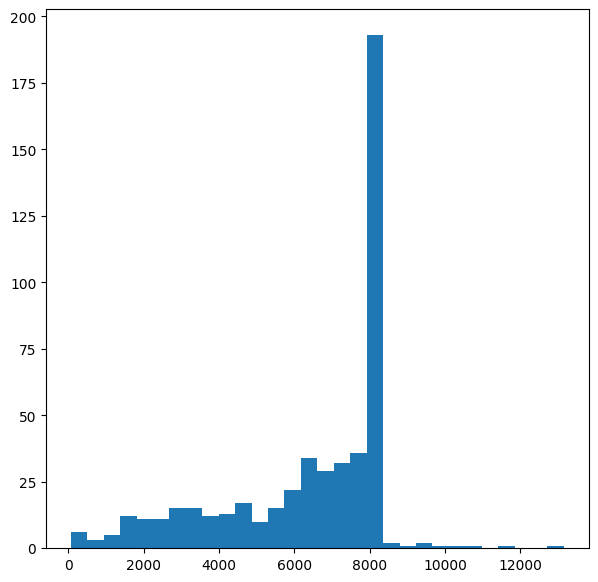

In [12]:
plt.figure(figsize=(7, 7))
plt.hist(list(days_per_ticker.values()), bins=30)
plt.show()

In [13]:
# Counter objects are a part of the collections module in Python's standard library.
# They are specialized dictionary subclasses designed to count hashable objects.
# A Counter is a collection where elements are stored as dictionary keys and their counts are stored
# as dictionary values.

Counter(list(days_per_ticker.values())).most_common(3)[
    0
]  # Counter(list(days_per_ticker.values())).most_common(3)[0][0] then extracts the number that occurs most often.

# 81 stocks contain 7881 days of data

(7944, 80)

## How are the stocks weighted with repect to the one with the longst history in the portfolio?

In [14]:
max_days_ticker = max(
    days_per_ticker, key=days_per_ticker.get
)  # find the ticker with the maximum number of days
max_days = days_per_ticker[
    max_days_ticker
]  # retrieve the value (number of days) for this ticker
print(
    f"The ticker with the maximum number of days is: {max_days_ticker}, with {max_days} days."
)

max_days = max(days_per_ticker.values())  # find the maximum number of days
weights_per_ticker = {
    ticker: days / max_days for ticker, days in days_per_ticker.items()
}  # Calculate the weight for each ticker, z-transform the weights should you wish to use them in ML applications
weights_per_ticker

The ticker with the maximum number of days is: LEN, with 13157 days.


{'A': 0.5693547161206962,
 'AAL': 0.2824352055939804,
 'AAPL': 0.603253021205442,
 'ABBV': 0.2103823059968078,
 'ABNB': 0.05837196929391199,
 'ABT': 0.6037850573839021,
 'ACGL': 0.4512426845025462,
 'ACN': 0.5907121684274531,
 'ADBE': 0.6034810367104964,
 'ADI': 0.6037850573839021,
 'ADM': 0.6037850573839021,
 'ADP': 0.5999087937979782,
 'ADSK': 0.5292999923994831,
 'AEE': 0.555749790985787,
 'AEP': 0.6037850573839021,
 'AES': 0.5204073877023637,
 'AFL': 0.6037850573839021,
 'AIG': 0.6037850573839021,
 'AIZ': 0.5872159306832865,
 'AJG': 0.6027969901953333,
 'AKAM': 0.46218742874515467,
 'ALB': 0.5702667781409135,
 'ALGN': 0.4382458007144486,
 'ALK': 0.6037850573839021,
 'ALL': 0.5988447214410579,
 'ALLE': 0.34057915938283806,
 'AMAT': 0.6037090522155507,
 'AMCR': 0.2427605077145246,
 'AMD': 0.6036330470471992,
 'AME': 0.6033290263737934,
 'AMGN': 0.6036330470471992,
 'AMP': 0.4795166071292848,
 'AMT': 0.5665425248916927,
 'AMZN': 0.5093106331230524,
 'ANET': 0.29429201185680626,
 'ANSS

## Alternatively, we could define a start and end date ourselves and make sure to select only those stocks with a densely populated history.

Densely here means that the stocks should have the same number of data. This ensures stocks thate were recently taken in are not selected as they do not contain enough data

In [15]:
selected_start_date = pd.Timestamp(2012, 1, 1)
selected_end_date = pd.Timestamp(2022, 12, 31)
df_filtered = df[
    (df["date"] >= selected_start_date) & (df["date"] <= selected_end_date)
]
df_filtered.groupby(
    "ticker"
).size().value_counts()  # 374 out of the 500 stocks are of the desired duration

2768    374
2769     14
2767      4
2770      3
2771      3
       ... 
2707      1
130       1
2772      1
2372      1
2497      1
Name: count, Length: 96, dtype: int64

If we wanted to just go for the mode directly, we could have achieved this by

In [16]:
mode_size = df_filtered.groupby("ticker").size().mode()[0]
mode_size

2768

And counted the number of stocks of that length using

In [17]:
df_common_size = (
    df_filtered.groupby("ticker")
    .filter(lambda x: len(x) == mode_size)
    .reset_index(drop=True)
)

df_common_size["ticker"].unique().__len__()

374

If we selected only those stocks that have an equal amount of days between our start and end day, we have to reduce our universe from 500 stocks to 374. This is a significant reduction that one should be sure to afford.

As an alternative way, we appreaciate the different length of the data and conduct the pattern analysis for each of them separately.

# How does each stock evolve in time?

We limit ourselves to onem year of data to see how each of the stocks in the portfolio performed relative to their starting price

In [18]:
def add_normalized_price(df: pd.DataFrame) -> pd.DataFrame:
    df["first_price_indicator"] = np.where(df.index == 0, 1, 0)
    df["first_price_value"] = df["first_price_indicator"] * df["close"]
    df["first_price_value"].replace(to_replace=0, method="ffill", inplace=True)
    df["normalized_price"] = df["close"] / df["first_price_value"]
    df.drop(columns=["first_price_indicator", "first_price_value"], inplace=True)
    return df

In [19]:
# implementation using a multi-indexed data frame
result = df_common_size.set_index(["ticker", "date"]).join(
    df_common_size.groupby("ticker").first().add_prefix("first_")
)  # dg.set_index(['Date','ListingId']) will be equivalent to the vectorized version
result["normalized_price"] = result["close"] / result["first_close"]

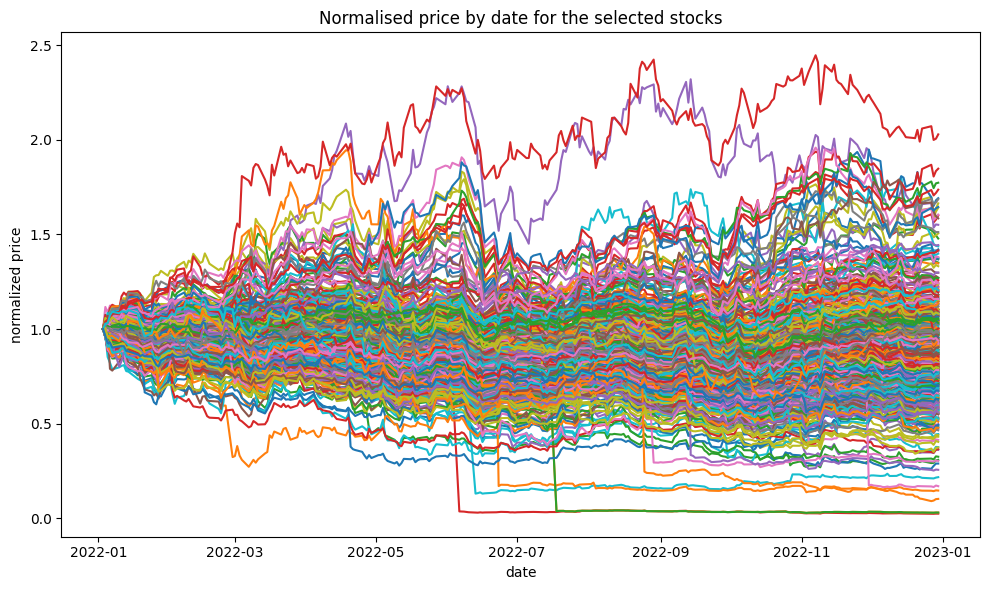

In [20]:
# plotting the data. Note you can select a nunber of stocks via the variable "counter" as well.

selected_start_date = pd.Timestamp(2022, 1, 1)
selected_end_date = pd.Timestamp(2022, 12, 31)

df_filtered = df[
    (df["date"] >= selected_start_date) & (df["date"] <= selected_end_date)
]
df_filtered

mode_size = df_filtered.groupby("ticker").size().mode()[0]

df_common_size = (
    df_filtered.groupby("ticker")
    .filter(lambda x: len(x) == mode_size)
    .reset_index(drop=True)
)

result = df_common_size.set_index(["ticker", "date"]).join(
    df_common_size.groupby("ticker").first().add_prefix("first_")
)  # dg.set_index(['Date','ListingId']) will be equivalent to the vectorized version
result["normalized_price"] = result["close"] / result["first_close"]

plt.figure(figsize=(10, 6))

counter = 0

for ticker, data in result.groupby(level="ticker"):
    plt.plot(
        data.index.get_level_values("date"), data["normalized_price"], label=ticker
    )
#     counter += 1
#     if counter == 20:
#         break

# plt.legend(title='Ticker', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Normalised price by date for the selected stocks")
plt.xlabel("date")
plt.ylabel("normalized price")
plt.tight_layout()
plt.show()

We see that the stock prices are not adapted to stock splits. As we work with intraday returns, we get away dealing with price-adjustments which, strictly speaking, is a topic in its own right. However, we do see the investment universe evolved, seemingly randomly, and there were constituents that performed positively, neutral, and negatively. 

Hence, selecting one stock in hindsight, and evaluating its buy-and-hold performance, is subject to bias. We will test in the following, how the candlestick patterns perform for the investment universe, to see whether they allow a a portfolion to be actively managed in a long-short fashion. 

# Candlestick analysis

We are now in a position to analyse the whole investment universe. Unfortunately, we now need to deal with a problem we so far go around with: "Big data analysis" comes with "big computational resources". 
Recall, we need to:
 - Loading data to memory coming from 500 stocks, with a history of up to 40 years,
 - Making the pattern recogniton logic act on them, where:
     - for every date, we create up to 61 new rows, where 61 is the number of candlestick patterns we are  able to identify using `talib`.
     
Unfortunately, this exceeds the memory resources of a standard workstation or laptop. 

In the following we hence limit ourselves to two years of data and outline how to proceed the analysis, but need to leave considering a wider time-interval to the interested reader whos has a more powerful machine available.

In [21]:
# the path to the data file is the same as for the notbook discussing the single-stock case.
data_filename = "SP500_daily_data_1980_to_2023.csv.gz"
notebooks_dir = Path("./../notebooks")
data_file_path = notebooks_dir.parent / "data" / data_filename

df = process_data(
    load_data(
        data_file_path,
        selected_start_date=pd.Timestamp(2019, 1, 1),
        selected_end_date=pd.Timestamp(2022, 12, 31),
    )
)

In [22]:
%%time
cs_signals_df = cs_pattern_recognition(df=df)

CPU times: user 4.65 s, sys: 5.84 s, total: 10.5 s
Wall time: 10.5 s


In [23]:
%%time
performance_metrics = cs_performance(cs_signals_df)

CPU times: user 87.1 ms, sys: 0 ns, total: 87.1 ms
Wall time: 86.9 ms


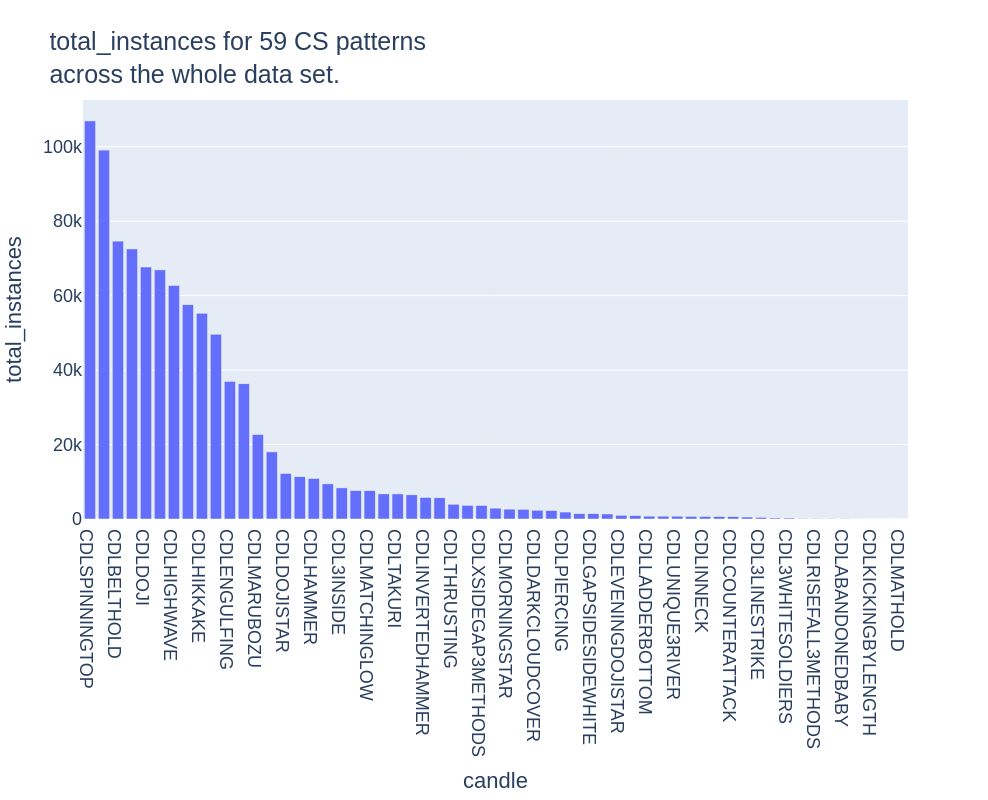

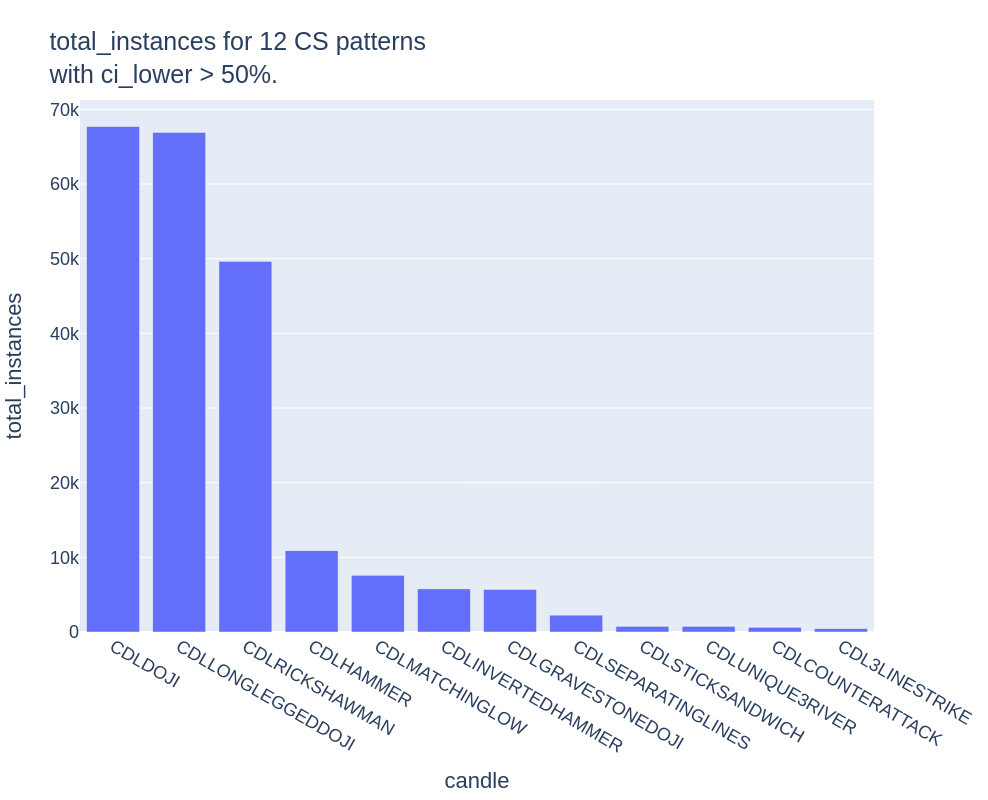

In [24]:
# plot all patterns, ranked by number of instances
plot_cs_performance(
    df=performance_metrics,
    criterion="total_instances",
    title_suffix="across the whole data set.",
)

# plot the patterns, ranked by number of instances, with a true-positive rate >50%.
plot_cs_performance(
    df=performance_metrics.query("ci_lower > 0.5").sort_values(
        by="total_instances", ascending=False
    ),
    criterion="total_instances",
    title_suffix="with ci_lower > 50%.",
)

Notable this time, appreciating more data, we indeed isntances where the lower part of the confidence interval is greater than 50%. This tells us we are 95% sure that these patterns indeed correctly predict the next day's intraday return. Conversely, we are now also in a position to identify counter-signals. These are instances where the upper part of the confidence interval is below the 50% threshold. Hence, it is indicated to take action for these signals in opposite direction of what they suggest, i.e. to take them as contrarian signals. 

Let us visualise these reults in the following.

In [25]:
performance_metrics.query("ci_lower > 0.5").sort_values(
    by=["ci_lower"], ascending=False
)

TP     FP  total_instances  precision    center  \
candle                                                                   
CDL3LINESTRIKE        254    190              444   0.572072  0.571454   
CDLINVERTEDHAMMER    3030   2742             5772   0.524948  0.524931   
CDLGRAVESTONEDOJI    2958   2733             5691   0.519768  0.519755   
CDLUNIQUE3RIVER       409    348              757   0.540291  0.540087   
CDLCOUNTERATTACK      342    287              629   0.543720  0.543455   
CDLLONGLEGGEDDOJI   33980  32928            66908   0.507862  0.507861   
CDLSEPARATINGLINES   1184   1076             2260   0.523894  0.523853   
CDLHAMMER            5576   5303            10879   0.512547  0.512543   
CDLRICKSHAWMAN      25188  24453            49641   0.507403  0.507403   
CDLMATCHINGLOW       3900   3691             7591   0.513766  0.513759   
CDLDOJI             34238  33455            67693   0.505783  0.505783   
CDLSTICKSANDWICH      408    352              760   0.536842  0.536657   

                      margin  ci_upper  ci_lower  TP_wilson  
candle                                                       
CDL3LINESTRIKE      0.045829  0.617282  0.525625   0.571454  
CDLINVERTEDHAMMER   0.012879  0.537810  0.512053   0.524931  
CDLGRAVESTONEDOJI   0.012976  0.532731  0.506779   0.519755  
CDLUNIQUE3RIVER     0.035413  0.575500  0.504674   0.540087  
CDLCOUNTERATTACK    0.038807  0.582262  0.504647   0.543455  
CDLLONGLEGGEDDOJI   0.003788  0.511649  0.504073   0.507861  
CDLSEPARATINGLINES  0.020573  0.544426  0.503280   0.523853  
CDLHAMMER           0.009391  0.521934  0.503152   0.512543  
CDLRICKSHAWMAN      0.004398  0.511800  0.503005   0.507403  
CDLMATCHINGLOW      0.011241  0.525000  0.502519   0.513759  
CDLDOJI             0.003766  0.509549  0.502017   0.505783  
CDLSTICKSANDWICH    0.035362  0.572019  0.501295   0.536657

In [26]:
performance_metrics.query("ci_upper < 0.5").sort_values(
    by=["ci_upper"], ascending=False
)

TP     FP  total_instances  precision    center  \
candle                                                                   
CDLSPINNINGTOP      53080  53849           106929   0.496404  0.496404   
CDLMARUBOZU         11173  11518            22691   0.492398  0.492399   
CDLBELTHOLD         36943  37701            74644   0.494923  0.494923   
CDLSHOOTINGSTAR      3697   3929             7626   0.484789  0.484797   
CDLLONGLINE         48672  50428            99100   0.491140  0.491141   
CDLSHORTLINE        28193  29360            57553   0.489862  0.489862   
CDLTRISTAR            320    383              703   0.455192  0.455436   
CDLCLOSINGMARUBOZU  35159  37383            72542   0.484671  0.484672   
CDLDARKCLOUDCOVER    1093   1259             2352   0.464711  0.464768   
CDLPIERCING           862   1008             1870   0.460963  0.461043   
CDL2CROWS             234    299              533   0.439024  0.439461   
CDLENGULFING        17525  19420            36945   0.474354  0.474356   
CDLEVENINGDOJISTAR    444    559             1003   0.442672  0.442891   
CDL3OUTSIDE          8330   9687            18017   0.462341  0.462349   
CDLEVENINGSTAR       1317   1601             2918   0.451337  0.451401   

                      margin  ci_upper  ci_lower  TP_wilson  
candle                                                       
CDLSPINNINGTOP      0.002997  0.499401  0.493408   0.496404  
CDLMARUBOZU         0.006504  0.498904  0.485895   0.492399  
CDLBELTHOLD         0.003587  0.498509  0.491336   0.494923  
CDLSHOOTINGSTAR     0.011214  0.496011  0.473583   0.484797  
CDLLONGLINE         0.003112  0.494253  0.488028   0.491141  
CDLSHORTLINE        0.004084  0.493946  0.485778   0.489862  
CDLTRISTAR          0.036713  0.492148  0.418723   0.455436  
CDLCLOSINGMARUBOZU  0.003637  0.488308  0.481035   0.484672  
CDLDARKCLOUDCOVER   0.020140  0.484909  0.444628   0.464768  
CDLPIERCING         0.022570  0.483612  0.438473   0.461043  
CDL2CROWS           0.041982  0.481443  0.397479   0.439461  
CDLENGULFING        0.005091  0.479448  0.469265   0.474356  
CDLEVENINGDOJISTAR  0.030681  0.473572  0.412209   0.442891  
CDL3OUTSIDE         0.007279  0.469629  0.455070   0.462349  
CDLEVENINGSTAR      0.018044  0.469444  0.433357   0.451401

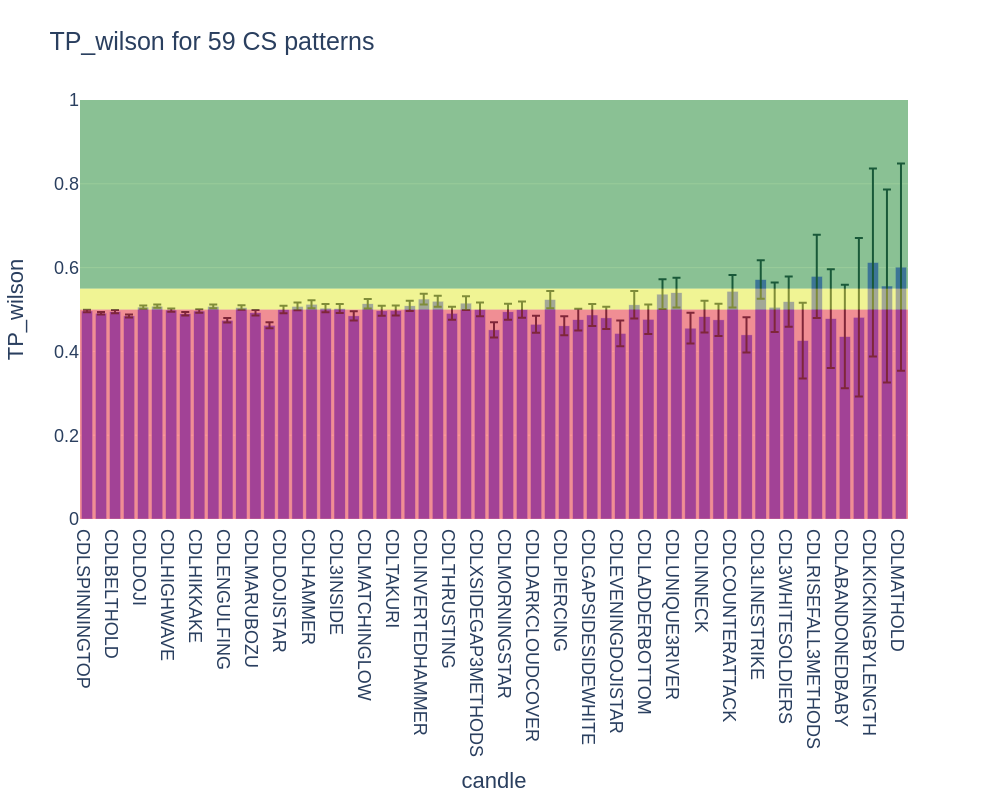

In [27]:
plot_cs_performance(
    df=performance_metrics, criterion="TP_wilson", plot_performance=True
)

Based on this analysis, we now name signals and contrarian signals:

In [28]:
performance_metrics.query("ci_lower > 0.5").index  # signals

Index(['CDLDOJI', 'CDLLONGLEGGEDDOJI', 'CDLRICKSHAWMAN', 'CDLHAMMER',
       'CDLMATCHINGLOW', 'CDLINVERTEDHAMMER', 'CDLGRAVESTONEDOJI',
       'CDLSEPARATINGLINES', 'CDLSTICKSANDWICH', 'CDLUNIQUE3RIVER',
       'CDLCOUNTERATTACK', 'CDL3LINESTRIKE'],
      dtype='object', name='candle')

In [29]:
performance_metrics.query("ci_upper < 0.5").index  # anti signals

Index(['CDLSPINNINGTOP', 'CDLLONGLINE', 'CDLBELTHOLD', 'CDLCLOSINGMARUBOZU',
       'CDLSHORTLINE', 'CDLENGULFING', 'CDLMARUBOZU', 'CDL3OUTSIDE',
       'CDLSHOOTINGSTAR', 'CDLEVENINGSTAR', 'CDLDARKCLOUDCOVER', 'CDLPIERCING',
       'CDLEVENINGDOJISTAR', 'CDLTRISTAR', 'CDL2CROWS'],
      dtype='object', name='candle')

If you want, you can test strategies that contain only those candlestick patterns that have proven to be profitable and/or those which manifsted themselves as anti-signals. 

Also you now can implement your own Machine-Learning logics to see whether you can come up with your own logic. Also, you can run the logic on a more potent machine, to see how the precision and confidence intervals change per candlestick pattern. 

# Applying candlestick analysis across the S&P 500 universe

Unfortunately, the data provider does not have OHLC data for the S&P 500 index. At the time of writing, an inquiry is still ongoing. In the following, we illustrate how we obtain a synthetic performance reference nontheless, namely by computing the mean intraday return at any day acroos all the oniverse assuming equal weights. This shoudl serve as an approximate solution that works with the data at hand.

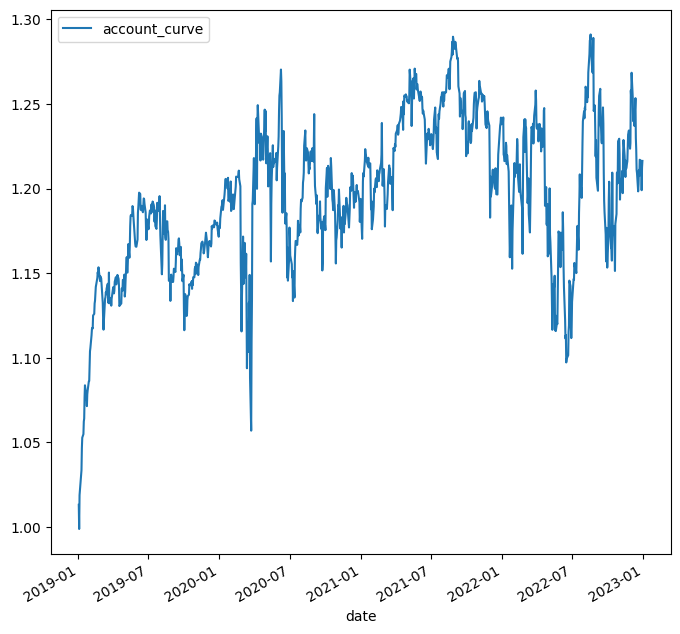

Annualised strategy return [%]: 0.0637
Annualised strategy standard deviation of returns [%]: 0.1624
Sharpe ratio of strategy: 0.3922


In [30]:
# synthetic S&P 500 intraday performacne
df_reference_strategy = (
    df[["ticker", "date", "intraday_return"]]
    .pivot_table(index="date", columns="ticker")
    .mean(axis=1)
)
df_reference_strategy = df_reference_strategy.rename("intraday_return").reset_index()
df_reference_strategy["account_curve"] = (
    1 + df_reference_strategy["intraday_return"]
).cumprod()
df_reference_strategy["cumsumret"] = df_reference_strategy["intraday_return"].cumsum()
df_reference_strategy.plot(x="date", y="account_curve", figsize=(8, 8))
plt.show()

compute_trading_strategy_performance(df=df_reference_strategy, verbose=True);

However, we can also opt for a method that compares the buy-and hold approach against employign the naive candlestick strategy. Recall the naive candlestick approach was to sum up the signal for each day across all the candlestick patterns. We can then compare the Sharpe Ration for both, the buy-and-hold approach, as well as the active candlestick approach and compare which of them delivers higher risk-adjusted returns, if at all.
This is carrie dout in the below, whearas we slightly modified the approach of the single-stock method from notebook 2. 

## Analysing Sharpe Ratios for a passive and acive trading strategy for the S&P 500 universe

We now turn our focus to comparing the Sharpe Ratios from both, passive and active trading strategies, examining their distribution through histograms, cumulative distribution functions, and box plots. Additionally, we employ specific functions for a detailed statistical analysis. 

Precisely, `analyse_Sharpe_Ratios_for_active_and_passive_strategies()` visualizes their distributions, `analyze_sharpe_ratios()` delves into their statistical characteristics, and `compare_sharpe_ratios()` statistically determines if the active strategy's Sharpe Ratios significantly outperform those of a reference strategy.

In [31]:
def analyse_Sharpe_Ratios_for_active_and_passive_strategies(
    SR_buy_and_hold: np.array, SR_naive_cs: np.array
) -> None:
    # determine the combined range of both Sharpe Ratios
    all_ratios = np.concatenate((SR_buy_and_hold, SR_naive_cs))
    min_edge = all_ratios.min()
    max_edge = all_ratios.max()
    bins = np.linspace(
        min_edge, max_edge, 40
    )  # 40 equal-width bins across the full range

    # compute empirical CDF for SR_buy_and_hold
    sorted_SR_buy_and_hold = np.sort(SR_buy_and_hold)
    yvals_buy_and_hold = np.arange(1, len(sorted_SR_buy_and_hold) + 1) / float(
        len(sorted_SR_buy_and_hold)
    )

    # compute empirical CDF for SR_naive_cs
    sorted_SR_naive_cs = np.sort(SR_naive_cs)
    yvals_naive_cs = np.arange(1, len(sorted_SR_naive_cs) + 1) / float(
        len(sorted_SR_naive_cs)
    )

    # plotting
    fig, axs = plt.subplots(3, 1, figsize=(10, 18))

    # histograms
    axs[0].hist(SR_buy_and_hold, bins=bins, alpha=0.5, label="Buy and hold")
    axs[0].hist(SR_naive_cs, bins=bins, alpha=0.5, label="Naive CS")
    axs[0].set_title("Comparison of Sharpe Ratios: Buy and hold vs. Naive CS")
    axs[0].set_xlabel("Sharpe Ratio")
    axs[0].set_ylabel("Frequency")
    axs[0].legend()

    # empirical CDFs
    axs[1].plot(
        sorted_SR_buy_and_hold,
        yvals_buy_and_hold,
        label="Buy and hold",
        marker=".",
        linestyle="none",
    )
    axs[1].plot(
        sorted_SR_naive_cs,
        yvals_naive_cs,
        label="Naive CS",
        marker=".",
        linestyle="none",
    )
    axs[1].set_title("Empirical CDF of Sharpe Ratios")
    axs[1].set_xlabel("Sharpe Ratio")
    axs[1].set_ylabel("CDF")
    axs[1].legend()
    axs[1].grid(True)

    # box Plots
    axs[2].boxplot([SR_buy_and_hold, SR_naive_cs], labels=["Buy and hold", "Naive CS"])
    axs[2].set_title("Box Plot of Sharpe Ratios")
    axs[2].set_ylabel("Sharpe Ratio")

    plt.tight_layout()
    plt.show()

    return None


def analyze_sharpe_ratios(SR_buy_and_hold: np.array, SR_naive_cs: np.array) -> None:
    print("Buy and Hold Strategy:")
    print(f"Mean Sharpe Ratio: {np.mean(SR_buy_and_hold):.4f}")
    print(f"Median Sharpe Ratio: {np.median(SR_buy_and_hold):.4f}")
    print(f"Kurtosis: {stats.kurtosis(SR_buy_and_hold):.4f}")
    print(f"Skewness: {stats.skew(SR_buy_and_hold):.4f}\n")

    print("Naive Candlestick Strategy:")
    print(f"Mean Sharpe Ratio: {np.mean(SR_naive_cs):.4f}")
    print(f"Median Sharpe Ratio: {np.median(SR_naive_cs):.4f}")
    print(f"Kurtosis: {stats.kurtosis(SR_naive_cs):.4f}")
    print(f"Skewness: {stats.skew(SR_naive_cs):.4f}")

    return None


def compare_sharpe_ratios(SR_buy_and_hold: np.array, SR_naive_cs: np.array) -> None:
    t_stat, p_value = stats.ttest_ind(
        SR_naive_cs, SR_buy_and_hold, alternative="greater"
    )

    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_value}")

    # Interpret the p-value
    if p_value < 0.05:
        print(
            "The naive candlestick strategy has significantly greater Sharpe Ratios than the buy-and-hold strategy at the 5% significance level."
        )
    else:
        print(
            "There is no significant difference in Sharpe Ratios in favour of the naive candlestick strategy over the buy-and-hold strategy at the 5% significance level."
        )

        return None

## First approach: Taking into account all candlestick patterns

Now, we compute the Sharpe Ratios for the active, as well as passive (reference) strategy. 

In [32]:
%%time 

# we should loop through all of the tickers to create trading signals for each stock

StrategyPerformance = namedtuple(
    "StrategyPerformance", ["SR_buy_and_hold", "SR_naive_cs"]
)
naive_cs_vs_buy_and_hold_performance = {}

for ticker in tickers:
    df_single_stock = df[df["ticker"] == ticker]
    cs_single_stock_signals_df = cs_signals_df[cs_signals_df["ticker"] == ticker]

    trading_signal = (
        cs_single_stock_signals_df.query("cs_pattern != 0")
        .pivot_table(index="date", columns="candle", values="cs_pattern", aggfunc="sum")
        .sum(axis=1)
        .loc[lambda x: x != 0]
    )

    performance_trading_signals = (
        df_single_stock[
            df_single_stock["date"].isin(
                [date + pd.DateOffset(days=1) for date in trading_signal.index]
            )
        ][["date", "intraday_return"]]
        .assign(account_curve=lambda x: (1 + x["intraday_return"]).cumprod())
        .assign(cumsumret=lambda x: x["intraday_return"].cumsum())
        .assign(time_between_signals=lambda x: x["date"].diff().dt.days)
    )

    (_, _, SR_buy_and_hold) = compute_trading_strategy_performance(df=df_single_stock)
    (_, _, SR_naive_cs) = compute_trading_strategy_performance(
        df=performance_trading_signals
    )

    naive_cs_vs_buy_and_hold_performance[ticker] = StrategyPerformance(
        SR_buy_and_hold=SR_buy_and_hold, SR_naive_cs=SR_naive_cs
    )

CPU times: user 50 s, sys: 755 µs, total: 50 s
Wall time: 50 s


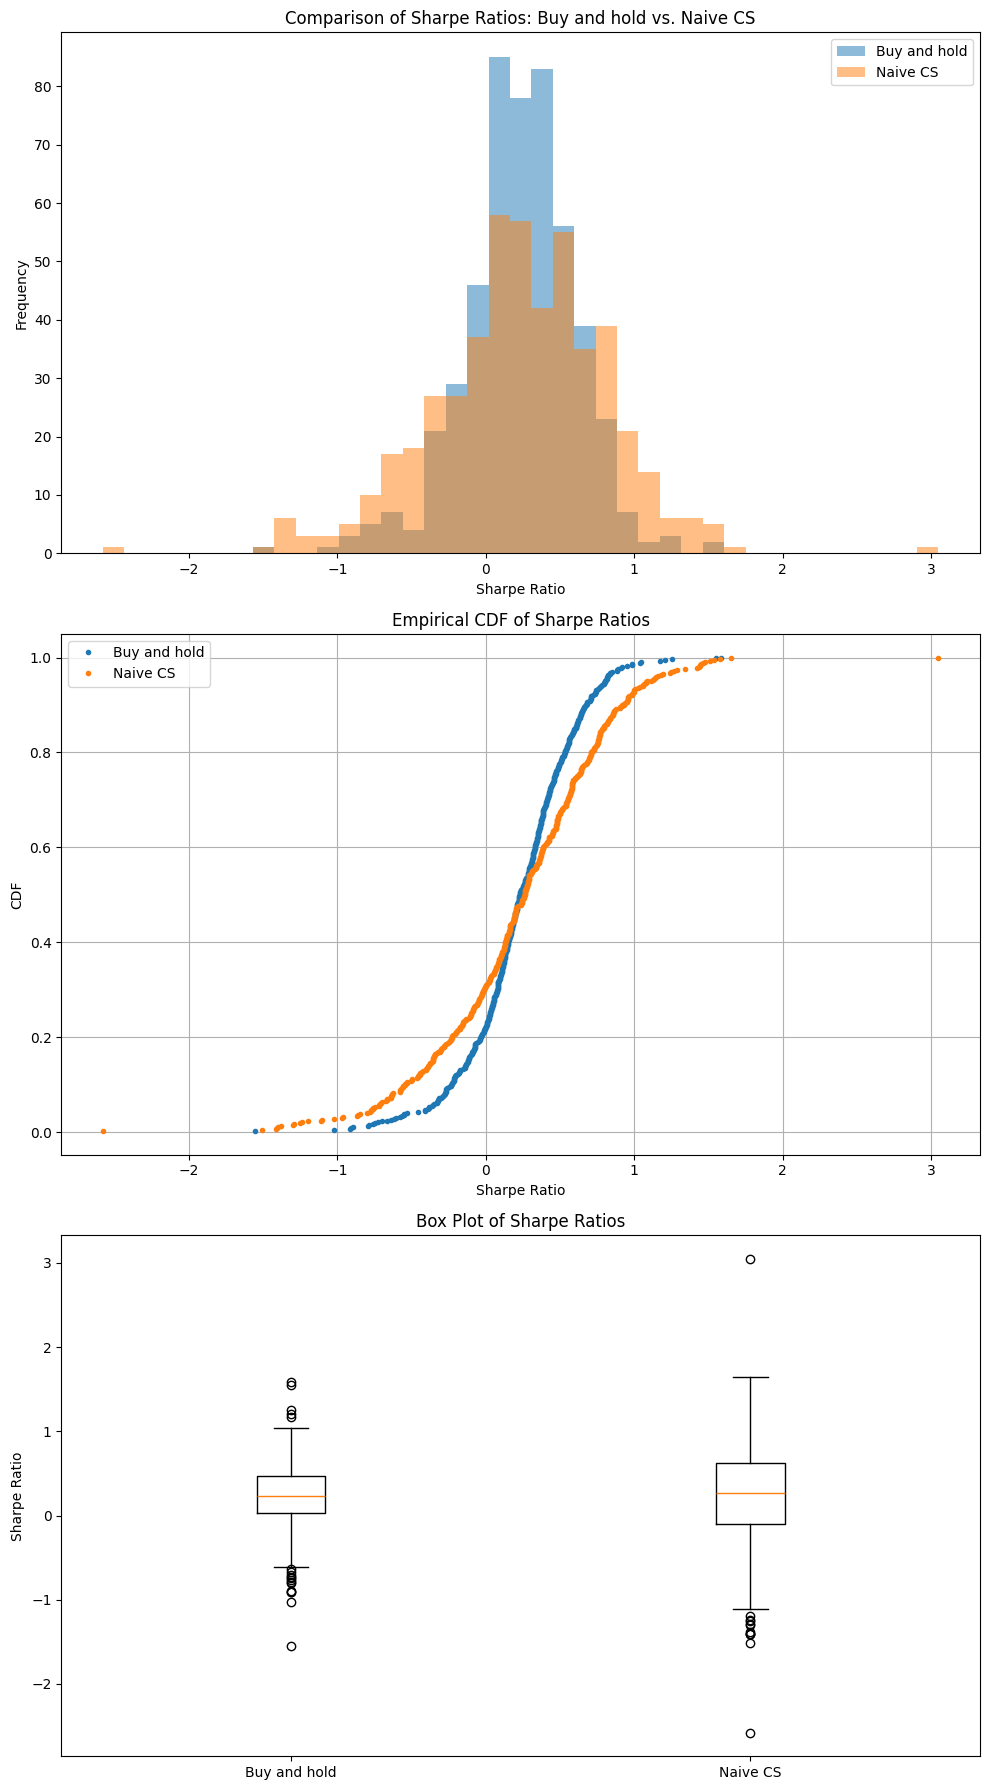

In [33]:
SR_buy_and_hold = np.array(
    [
        performance.SR_buy_and_hold
        for performance in naive_cs_vs_buy_and_hold_performance.values()
        if not np.isnan(performance.SR_buy_and_hold)
    ]
)
SR_naive_cs = np.array(
    [
        performance.SR_naive_cs
        for performance in naive_cs_vs_buy_and_hold_performance.values()
        if not np.isnan(performance.SR_naive_cs)
    ]
)

analyse_Sharpe_Ratios_for_active_and_passive_strategies(
    SR_buy_and_hold=SR_buy_and_hold, SR_naive_cs=SR_naive_cs
)

In [34]:
analyze_sharpe_ratios(SR_buy_and_hold=SR_buy_and_hold, SR_naive_cs=SR_naive_cs)

Buy and Hold Strategy:
Mean Sharpe Ratio: 0.2293
Median Sharpe Ratio: 0.2298
Kurtosis: 1.6132
Skewness: -0.3861

Naive Candlestick Strategy:
Mean Sharpe Ratio: 0.2325
Median Sharpe Ratio: 0.2617
Kurtosis: 1.7315
Skewness: -0.2999


Notably, both the mean and the median Sharpe Ratio for the naive candlestick approach (active trading strategy) are higher than for the passive (buy-and-hold) approach. Interestingly, also the skewness is slighly lower for the active approach. Recall that skewness values close to zero suggest a symmetrical distribution of returns around the mean. For the buy-and-hold strategy, a skewness of -0.3861 indicates a skew to the left, suggesting a distribution with a fatter left tail indicating more frequent negative extreme returns than positive ones. The candlestick approach's skewness of -0.2999 also indicates a leftward skew but to a lesser extent, suggesting a slightly more symmetric distribution of returns around the mean compared to the buy-and-hold strategy. 

Unfortunately, the extra returns obtained form the candlestick approach do not come for free: They are also more risk as indicated by the larger kurtosis. Also note we did not assume any transation costs. For a trading company, a market maker, or a large bank, which are in a position to negotiate lower transaction costs than retail traders, these are less of an issue. However, an active approach involving daily transactions for a retail trader is disadvantageous, to say the least. The active candlestick strategy hence appears more suitable for risk seeking speculatnts who are in pursuit of "high-risk-high-return" bets. 

However, it is noted that the outperformace of mean return, median return, and a smaller skew for the active candlestick approach are indeed interesting observations. In order to determine whether higher Sharpe Ratios for the candlestick approach are statistically significantly greater than the ones for the passive strategy, we perform a one-sided t-test.

In [35]:
compare_sharpe_ratios(SR_buy_and_hold, SR_naive_cs)

t-statistic: 0.1020279443073558
p-value: 0.4593775985116076
There is no significant difference in Sharpe Ratios in favour of the naive candlestick strategy over the buy-and-hold strategy at the 5% significance level.


## Second approach: Filter only statisticaly significant cs patterns

In [36]:
positive_signals = performance_metrics.query("ci_lower > 0.5").index  # signals
counter_signals = performance_metrics.query(
    "ci_upper < 0.5"
).index  # anti-signals/contrarians

In [37]:
%%time 

StrategyPerformance = namedtuple(
    "StrategyPerformance", ["SR_buy_and_hold", "SR_naive_cs"]
)
naive_cs_vs_buy_and_hold_performance = {}

for ticker in tickers:
    df_single_stock = df[df["ticker"] == ticker]
    cs_single_stock_signals_df = cs_signals_df[cs_signals_df["ticker"] == ticker]

    # create a copy for modification
    filtered_signals_df = cs_single_stock_signals_df.copy()

    # apply the filter directly to this copy
    filter_mask = filtered_signals_df.index.get_level_values("candle").isin(
        positive_signals.union(counter_signals)
    )
    filtered_signals_df = filtered_signals_df.loc[filter_mask]

    # adjust 'cs_pattern' by multiplying by -1 for counter signals
    counter_signals_mask = filtered_signals_df.index.get_level_values("candle").isin(
        counter_signals
    )
    filtered_signals_df.loc[counter_signals_mask, "cs_pattern"] *= -1

    trading_signal = (
        filtered_signals_df.query("cs_pattern != 0")
        .pivot_table(index="date", columns="candle", values="cs_pattern", aggfunc="sum")
        .sum(axis=1)
        .loc[lambda x: x != 0]
    )

    performance_trading_signals = (
        df_single_stock[
            df_single_stock["date"].isin(
                [date + pd.DateOffset(days=1) for date in trading_signal.index]
            )
        ][["date", "intraday_return"]]
        .assign(account_curve=lambda x: (1 + x["intraday_return"]).cumprod())
        .assign(cumsumret=lambda x: x["intraday_return"].cumsum())
        .assign(time_between_signals=lambda x: x["date"].diff().dt.days)
    )

    (_, _, SR_buy_and_hold) = compute_trading_strategy_performance(df=df_single_stock)
    (_, _, SR_naive_cs) = compute_trading_strategy_performance(
        df=performance_trading_signals
    )

    naive_cs_vs_buy_and_hold_performance[ticker] = StrategyPerformance(
        SR_buy_and_hold=SR_buy_and_hold, SR_naive_cs=SR_naive_cs
    )

CPU times: user 48.8 s, sys: 9.18 ms, total: 48.8 s
Wall time: 48.9 s


In [38]:
SR_buy_and_hold = np.array(
    [
        performance.SR_buy_and_hold
        for performance in naive_cs_vs_buy_and_hold_performance.values()
        if not np.isnan(performance.SR_buy_and_hold)
    ]
)
SR_naive_cs = np.array(
    [
        performance.SR_naive_cs
        for performance in naive_cs_vs_buy_and_hold_performance.values()
        if not np.isnan(performance.SR_naive_cs)
    ]
)

In [39]:
analyze_sharpe_ratios(SR_buy_and_hold=SR_buy_and_hold, SR_naive_cs=SR_naive_cs)

Buy and Hold Strategy:
Mean Sharpe Ratio: 0.2293
Median Sharpe Ratio: 0.2298
Kurtosis: 1.6132
Skewness: -0.3861

Naive Candlestick Strategy:
Mean Sharpe Ratio: 0.2822
Median Sharpe Ratio: 0.3150
Kurtosis: 0.7447
Skewness: -0.2592


In [40]:
compare_sharpe_ratios(SR_buy_and_hold, SR_naive_cs)

t-statistic: 1.6637194409255192
p-value: 0.0482428136676386
The naive candlestick strategy has significantly greater Sharpe Ratios than the buy-and-hold strategy at the 5% significance level.


Recall from above, the naive Candlestick strategy utilizing all patterns was characterised by the following performacne metrics:

```
Mean Sharpe Ratio: 0.2325
Median Sharpe Ratio: 0.2617
Kurtosis: 1.7315
Skewness: -0.2999
```

# Conclusion

Upon filtering the candlestick signals and contrarian signals that were found to be indicating a price move on the next day at the 5% significance level, we could improve the all performance statistics, based on the Sharpe Ratio, in all four categories examined. The full set consists of 61 candlestick patterns, whereas the filtered approach consists of 12 signals and 15 counter signals. 

The signals were identified at the 5% significance level to be:

```
Index(['CDLDOJI', 'CDLLONGLEGGEDDOJI', 'CDLRICKSHAWMAN', 'CDLHAMMER',
       'CDLMATCHINGLOW', 'CDLINVERTEDHAMMER', 'CDLGRAVESTONEDOJI',
       'CDLSEPARATINGLINES', 'CDLSTICKSANDWICH', 'CDLUNIQUE3RIVER',
       'CDLCOUNTERATTACK', 'CDL3LINESTRIKE'],
      dtype='object', name='candle')
```

The contrarian signals were identified at the 5% significance level to be:
```
Index(['CDLSPINNINGTOP', 'CDLLONGLINE', 'CDLBELTHOLD', 'CDLCLOSINGMARUBOZU',
       'CDLSHORTLINE', 'CDLENGULFING', 'CDLMARUBOZU', 'CDL3OUTSIDE',
       'CDLSHOOTINGSTAR', 'CDLEVENINGSTAR', 'CDLDARKCLOUDCOVER', 'CDLPIERCING',
       'CDLEVENINGDOJISTAR', 'CDLTRISTAR', 'CDL2CROWS'],
      dtype='object', name='candle')
```

Notably, the filtered candlestick approach outperforms the naive buy strategy in all four performance categories investigated. Moreover, a one-sided `t-test` revealed that the Sharpe Ratios obtained by the filtered candlestick approach is greated than those obtained by the naive buy approach at the 5% level.

In further research, one could run the very same code on a more potent machine and simply select a longer data range when loading in the data, to see whether the results reported here still hold. Also, one could attempt an expanding-window approach regarding the considered time-frame to investigate how performance changes in time and whether there are stocks for which the candlestick approach works particularly good or bad. The data source considered for this analysis were the past two years for all S&P 500 components, although for some stocks, there exists data dating back to the 1980ies. Assuming a densely populated data this equates to an upper boundary of 20 000 years of daily stock OHLC data.


It remains, however, that the level of analysis carried out and presented here, required access to proprietary data and significant computing power. These could be, for example, the High Performance Computing (HPC) facilities at Imperial College, or a potent private institution. Moreover, an active trading approach is predominantly aimed at players like large hedge funds and investment banks which still have proprietary trading teams, and that are in a position to negotiate low transaction costs. They should also be potent enough to observe, and act, on data streams across the entire S&P 500 universe. An extention to any other index, such as the STOXX600 or any Asian index is easily diable using the existing code. 

For fund managers, with a more passive approach, the presented analysis can be interesting to optimise their entry points opon which to accummulate or offload positions. 

For brokers, the presented analysis is useful to craft an arrival strategies to which to adopt their execution logics based on an oppinion whether a stock goes up or down. In case of no signal on a particularly stock, one then would simply fall back to a default behaviour.   

# END

# Appendix

## ML approach

The author cannot run the ML approach as we do not have enough memory available to load the required history of the stocks. ML methods are inherently data hungy, so loading just two years of data per stock will not be enough for meaningful results. Also, we cannot mix the history of one stock with the history of another, as financial data is chronological in nature. 